# 3 Klassifikation des Objekttyps (1/4)
Ziel dieser Aufgabe ist es, ein Modell zu erstellen, welches durch beliebige Metriken eine akkurate Vorhersage über den Typ der Immobilie erstellt.

Wir vergleichen hier drei Ansätze miteinander

## Importieren der benötigten Libraries und Daten

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.gabonisator import Gabonisator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

Die Daten beziehen wir aus unserem Data Repository auf GitHub.

In [2]:
# read clean data + plz data
data = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv"
)
data = data[["price", "zip_code", "living_space", "rooms", "type"]]
plz = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/plz_data.csv"
)

## Datenverarbeitung

Um unsere kategorialen Zielvariable Type vorherzusagen, müssen wir sie in Dummies umwandeln, da wir nur numerische Werte berechnen können.

Zunächst kombinieren wir unseren reduzierten Wohnungsdatensatz mit unserem Postleitzahl Datensatz, um weitere Features zu erhalten.

In [3]:
# join clean data with plz data on plz
data = pd.get_dummies(data, columns=["type"])
data = data.merge(plz, how="inner", left_on="zip_code", right_on="PLZ")
data = data.drop(columns=["PLZ", "zip_code"])

Da unser Datensatz nur wenig NAs hat, verwerfen wir diese Observationen. Uns bleiben noch um die 11000 Datensätze.

In [4]:
# drop NAs
data = data.dropna()
# print new number of observations
len(data)

10548

Unsere Daten spalten wir danach in Features und Zielvariablen.

In [5]:
# define columns for X and y
y_cols = data.columns[data.columns.str.startswith("type_")]
X_cols = list(set(data._get_numeric_data().columns) - set(y_cols))

# convert pandas data to numpy arrays
X = data[X_cols].values
y = data[y_cols].values

Danach skalieren wir unsere Features mit einem StandardScaler auf die Werte aus unserem ganzen Datensatz.

In [6]:
# scale data to whole dataset
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Unsere Daten unterteilen wir danach auf Trainings- und Validierungsdaten.

In [7]:
# split train and val data (70%/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=420)

Hier wandeln wir unsere Numpy Werte in Float32 Werte, damit die Berechnung durch PyTorch effizienter verlauft.

In [8]:
# create tensors from numpy arrays
X_train_pytorch = torch.from_numpy(X_train.astype(np.float32))
X_val_pytorch = torch.from_numpy(X_val.astype(np.float32))
y_train_pytorch = torch.from_numpy(y_train.astype(np.float32))
y_val_pytorch = torch.from_numpy(y_val.astype(np.float32))

# Modelle

## Neuronal Network

Die Architektur unseres neuronalen Netzes sieht so aus:

<svg xmlns="http://www.w3.org/2000/svg" style="cursor: move; background: white;" width="380" height="185"><g transform="translate(-743.5554710569938,-326.8616196843533)scale(1.1)"><polygon class="poly" id="fc_0" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="718.5,344.6489719263484 728.5,344.6489719263484 828.2020561473032,444.3510280736516 818.2020561473032,444.3510280736516"></polygon><polygon class="poly" id="fc_1" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="830.2020561473032,371.87258300203047 840.2020561473032,371.87258300203047 885.4568901432423,417.1274169979695 875.4568901432423,417.1274169979695"></polygon><polygon class="poly" id="fc_2" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="887.4568901432422,371.87258300203047 897.4568901432422,371.87258300203047 942.7117241391812,417.1274169979695 932.7117241391812,417.1274169979695"></polygon><polygon class="poly" id="fc_3" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="944.7117241391812,387.07537879754125 954.7117241391812,387.07537879754125 969.5609665440987,401.92462120245875 959.5609665440987,401.92462120245875"></polygon><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="818.2020561473032" y2="444.3510280736516"></line><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="718.5" y2="344.6489719263484"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="828.2020561473032" y1="444.3510280736516" x2="875.4568901432422" y2="417.1274169979695"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="728.5" y1="344.6489719263484" x2="830.2020561473032" y2="371.87258300203047"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="885.4568901432422" y1="417.1274169979695" x2="932.7117241391812" y2="417.1274169979695"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="840.2020561473032" y1="371.87258300203047" x2="887.4568901432422" y2="371.87258300203047"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="942.7117241391812" y1="417.1274169979695" x2="959.5609665440987" y2="401.92462120245875"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="897.4568901432422" y1="371.87258300203047" x2="944.7117241391812" y2="387.07537879754125"></line><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="718.5" y="329.6489719263484">1x141</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="830.2020561473032" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="887.4568901432422" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="944.7117241391812" y="372.07537879754125">1x21</text></g></svg>

Dieses Modell erstellen wir danach und definieren eine Learning Rate, eine Lossfunction und ein Optimizer.
Als Lossfunction nehmen wir die Binary-Crossentropy und als Optimizer Adam.
Danach trainieren wir unser Modell und speichern unsere Losses nach jeder Epoche.

In [9]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train_pytorch)
    # loss function
    loss_train = lossf(y_pred, y_train_pytorch)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val_pytorch)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val_pytorch)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
    )
    print(
        f"   Best val loss: {np.min(loss_val_arr):.4f} at Epoch {np.argmin(loss_val_arr) + 1}"
    )

Epoch:   500/10000 | Loss train: 0.0912 | Loss val: 0.0914
Epoch:  1000/10000 | Loss train: 0.0593 | Loss val: 0.0599
Epoch:  1500/10000 | Loss train: 0.0536 | Loss val: 0.0546
Epoch:  2000/10000 | Loss train: 0.0504 | Loss val: 0.0519
Epoch:  2500/10000 | Loss train: 0.0475 | Loss val: 0.0496
Epoch:  3000/10000 | Loss train: 0.0454 | Loss val: 0.0481
Epoch:  3500/10000 | Loss train: 0.0439 | Loss val: 0.0474
Epoch:  4000/10000 | Loss train: 0.0427 | Loss val: 0.0470
Epoch:  4500/10000 | Loss train: 0.0416 | Loss val: 0.0468
Epoch:  5000/10000 | Loss train: 0.0406 | Loss val: 0.0468
Epoch:  5500/10000 | Loss train: 0.0396 | Loss val: 0.0470
Epoch:  6000/10000 | Loss train: 0.0387 | Loss val: 0.0472
Epoch:  6500/10000 | Loss train: 0.0378 | Loss val: 0.0476
Epoch:  7000/10000 | Loss train: 0.0368 | Loss val: 0.0481
Epoch:  7500/10000 | Loss train: 0.0359 | Loss val: 0.0488
Epoch:  8000/10000 | Loss train: 0.0349 | Loss val: 0.0497
Epoch:  8500/10000 | Loss train: 0.0339 | Loss val: 0.05

Um einen Überblick zu erhalten, wie gut das Modell jetzt trainiert wurde, visualisieren wir unsere Losses nach jeder Epoche.

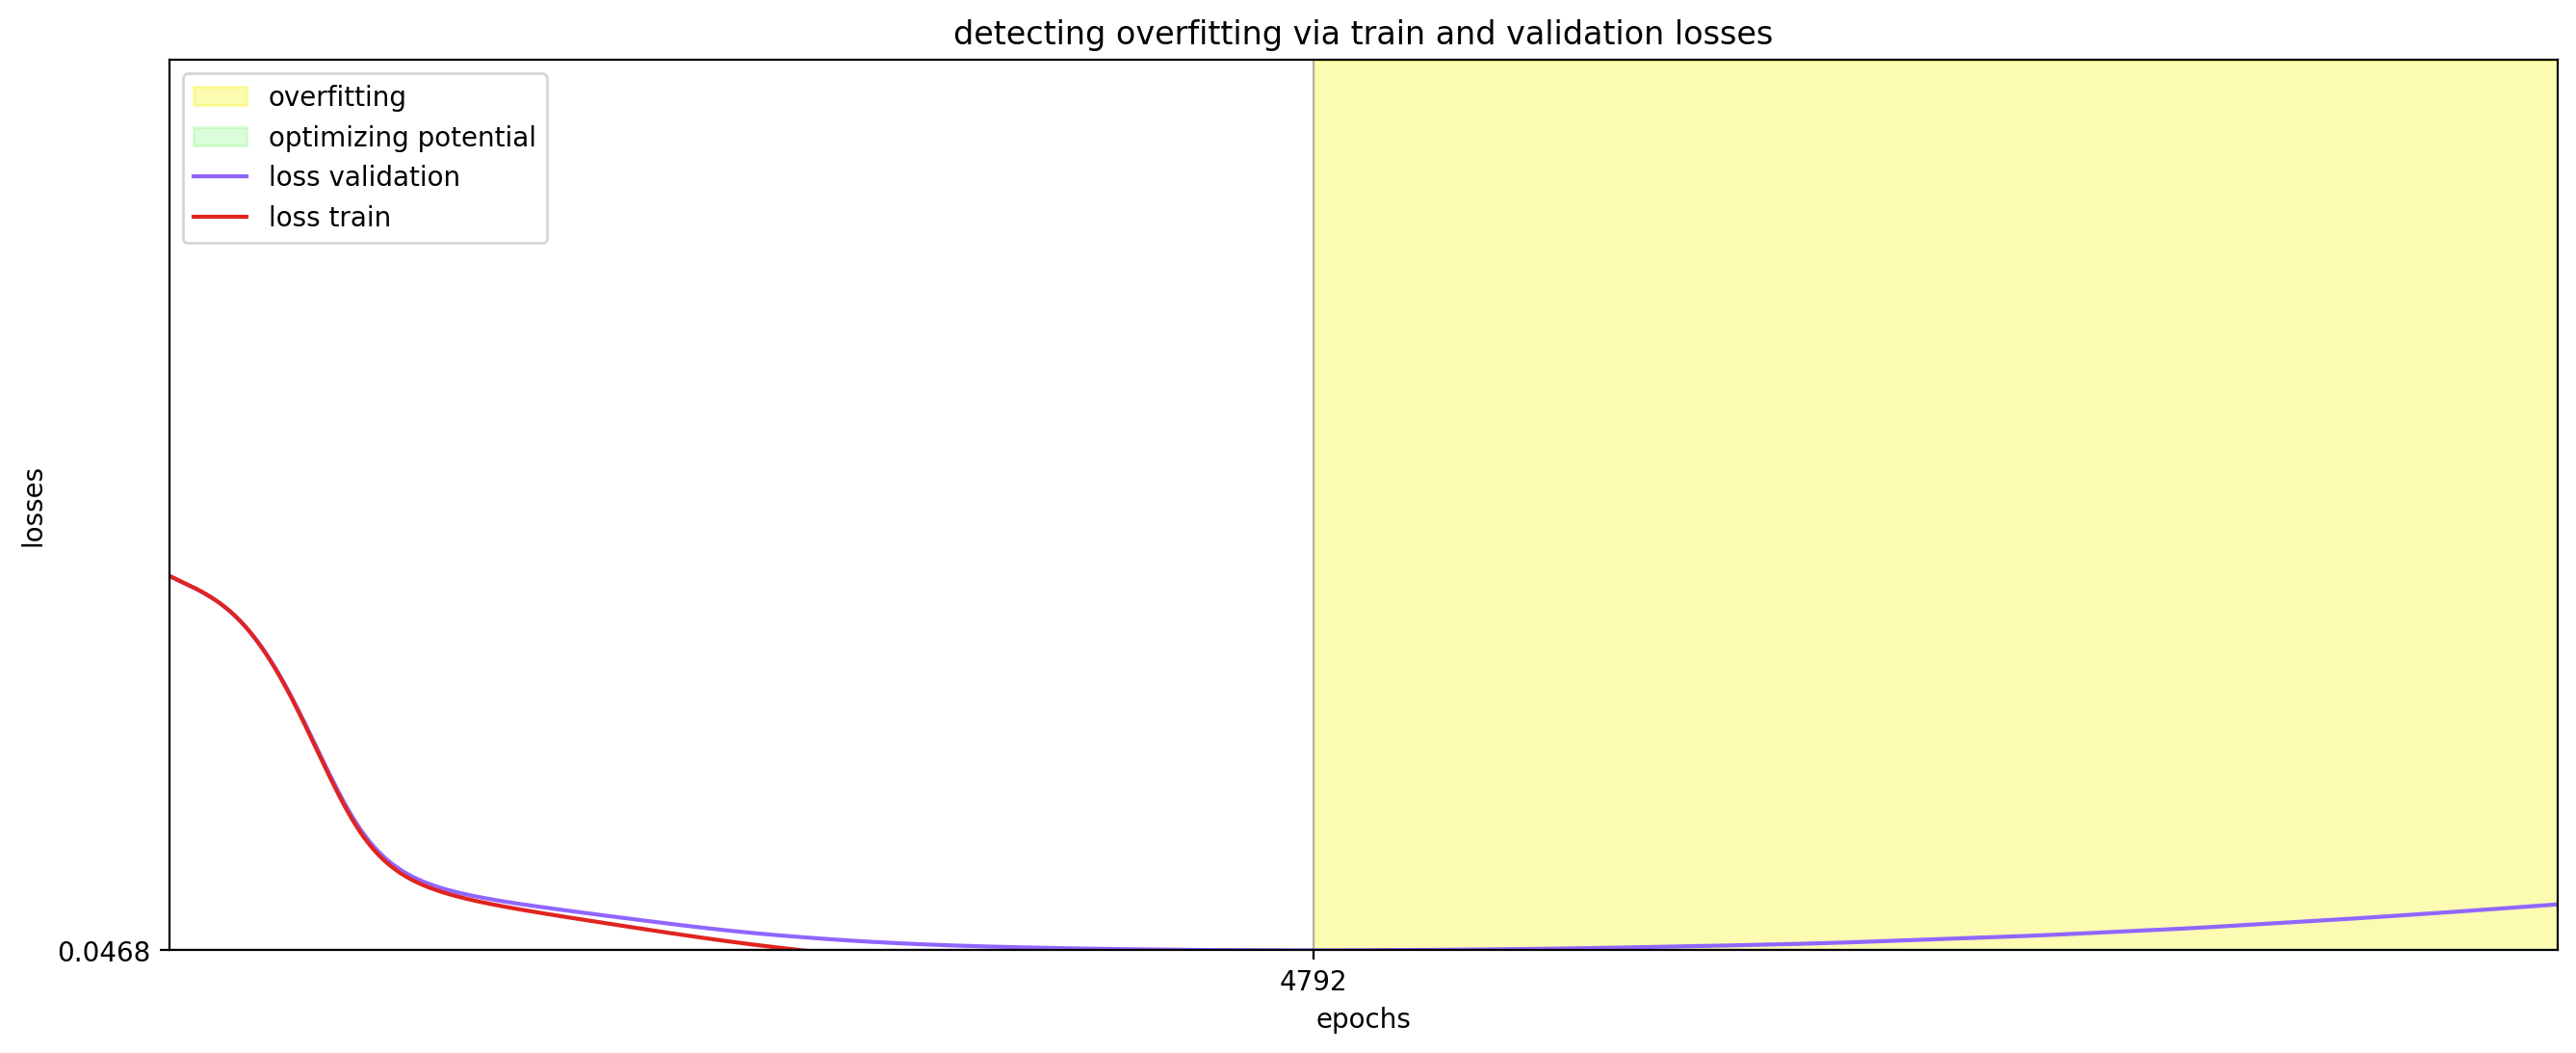

In [10]:
# visualize score
ymin = 0.06
ymax = 0.20
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

Wie wir hier erkennen können, passiert nach einer bestimmten Zahl Iterationen overfitting, da der Loss Wert unseres Validierungsdatensatzes steigt, anstatt zu sinken. Um dies zu bekämpfen, muss das Modell selbst erkennen, dass Overfitting stattfindet und frühzeitig abbrechen. Dafür implemntieren wir ein Early Stopping, welches überprüft, ob der letzte Loss Wert kleiner ist, als der aktuelle. Falls dies der Fall ist, hört das Modell auf zu trainieren.

In [11]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train_pytorch)
    # loss function
    loss_train = lossf(y_pred, y_train_pytorch)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val_pytorch)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val_pytorch)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # loss val goes up too much -> EarlyStop
    if np.round(np.min(loss_val_arr), 4) != np.round(loss_val.item(), 4):
        print("Early Stopping!")
        break

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    score = (
        (model(X_val_pytorch).argmax(axis=1) == y_val_pytorch.argmax(axis=1)).sum() / y_val.shape[0]
    ).item()
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f} | Score: {score:.4f}"
    )


Epoch:   500/10000 | Loss train: 0.0886 | Loss val: 0.0885
Epoch:  1000/10000 | Loss train: 0.0588 | Loss val: 0.0592
Epoch:  1500/10000 | Loss train: 0.0528 | Loss val: 0.0540
Epoch:  2000/10000 | Loss train: 0.0493 | Loss val: 0.0511
Epoch:  2500/10000 | Loss train: 0.0467 | Loss val: 0.0490
Epoch:  3000/10000 | Loss train: 0.0449 | Loss val: 0.0478
Epoch:  3500/10000 | Loss train: 0.0436 | Loss val: 0.0472
Epoch:  4000/10000 | Loss train: 0.0424 | Loss val: 0.0468
Epoch:  4500/10000 | Loss train: 0.0414 | Loss val: 0.0466
Epoch:  5000/10000 | Loss train: 0.0405 | Loss val: 0.0466
Early Stopping!
---
Final Run
Epoch:  5058/10000 | Loss train: 0.0404 | Loss val: 0.0467 | Score: 0.6303


Jetzt visualisieren wir unsere Ergebnisse anhand der gleichen Visualisierung wie vorhin.

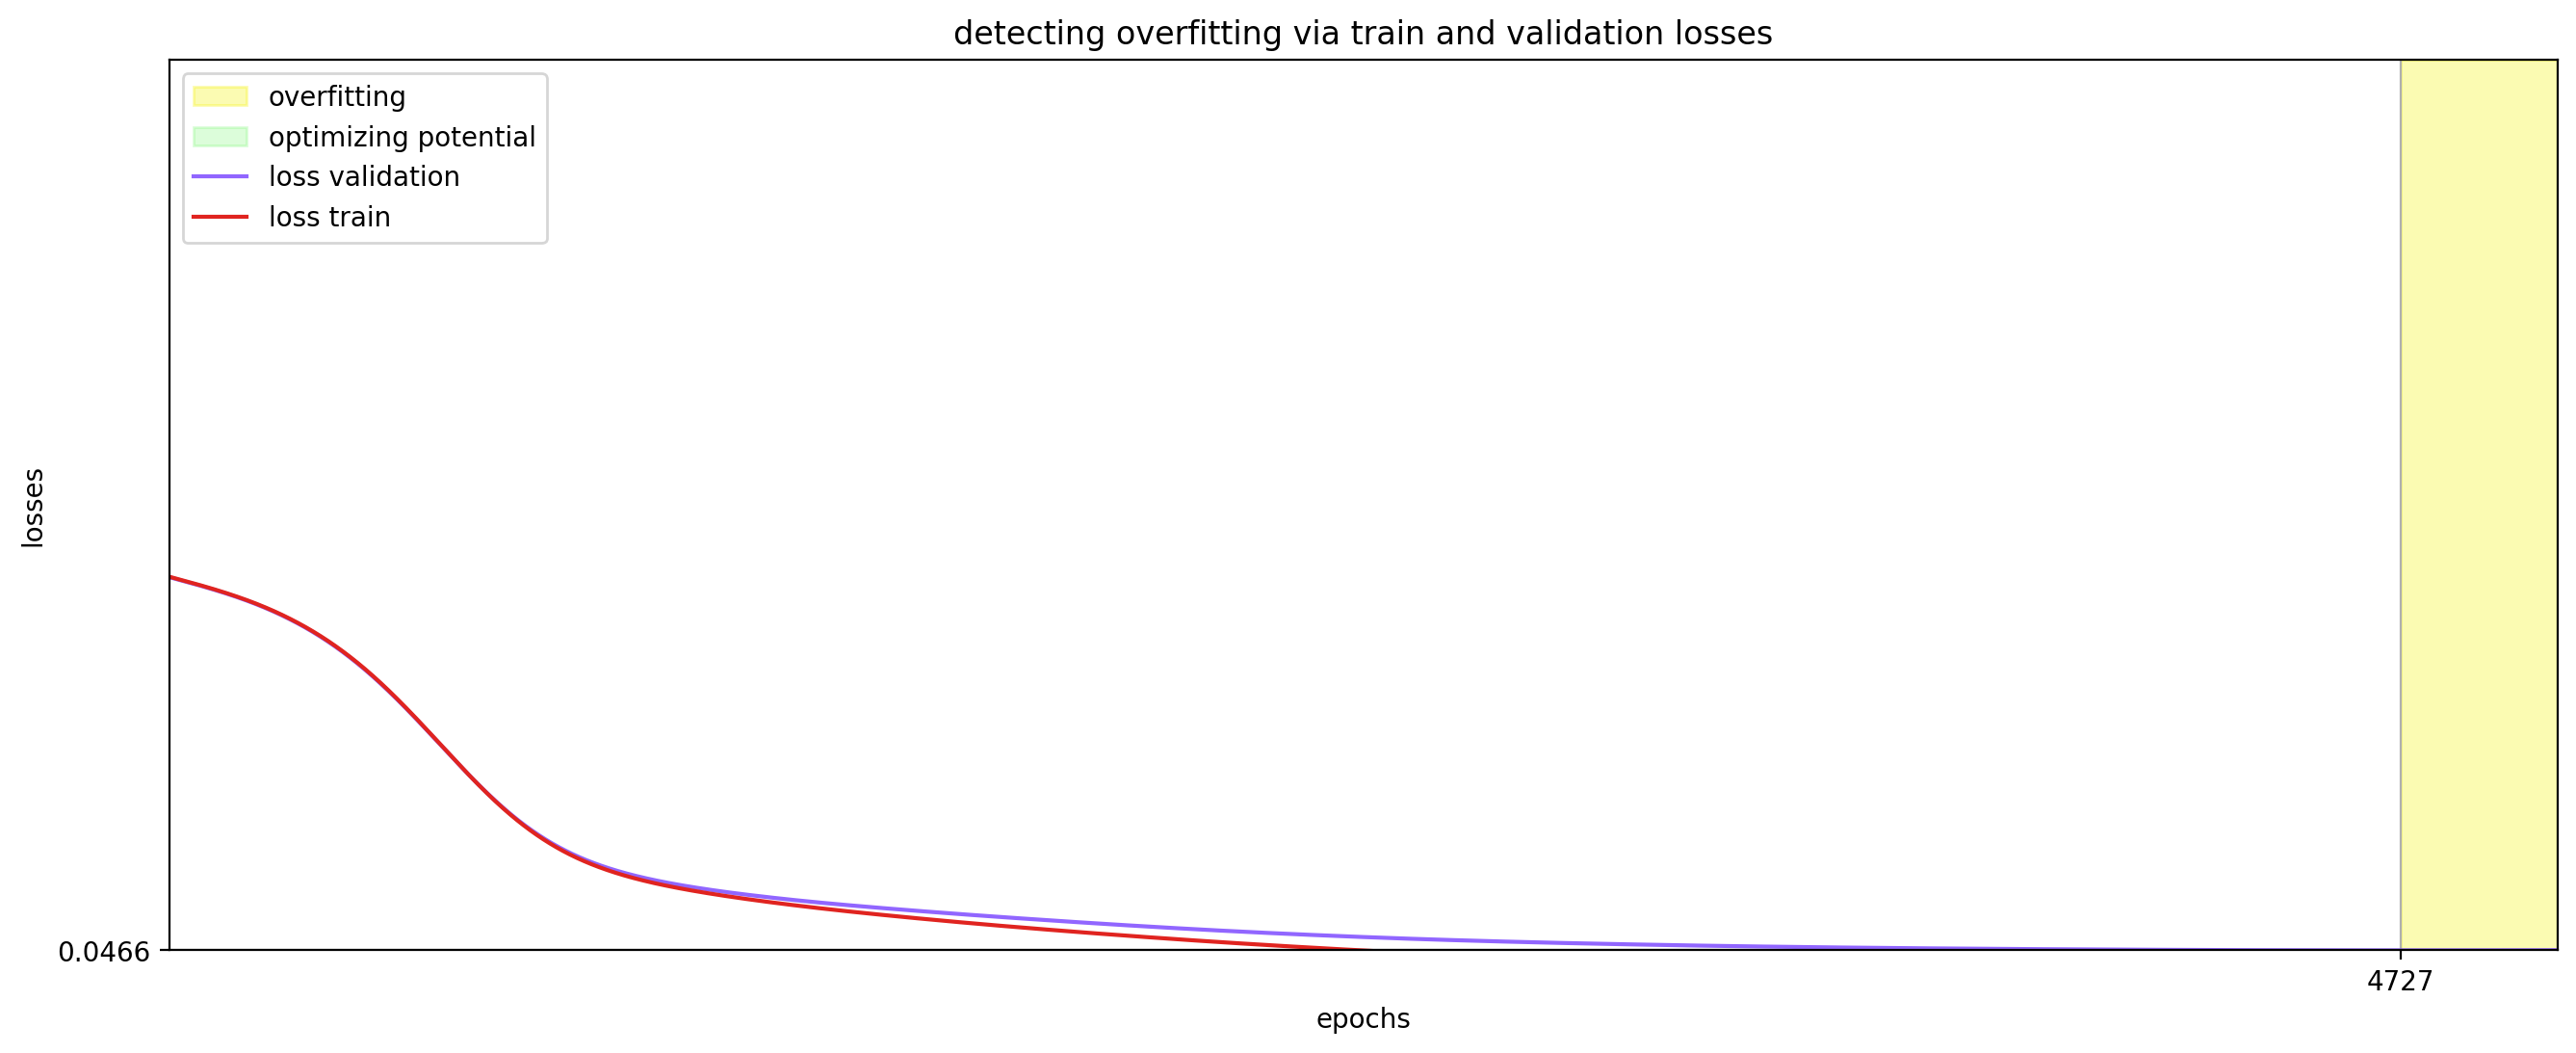

In [12]:
# visualize score
ymin = 0.06
ymax = 0.20
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

In [106]:
print(
    """
    Unser Modell bricht jetzt frühzeitig ab und verhindert somit overfitting.\n
    Unsere Accuracy ist mit diesem Modell ca. {}%
    """.format(
        np.round(score, 2)
    )
)


    Unser Modell bricht jetzt frühzeitig ab und verhindert somit overfitting.

    Unsere Accuracy ist mit diesem Modell ca. 0.52%
    


## K Neighbors Classifier

Hier trainieren wir mehrere Modelle, welche wir anhand verschiedener Anzahl Neighbors erstellen. Für jedes Modell berechnen wir die Accuracy und speichern diese ab.

In [97]:
scores = np.array([(i, KNeighborsClassifier(i).fit(X_train, y_train).score(X_val, y_val)) for i in tqdm(range(1, 5))])

  0%|          | 0/4 [00:00<?, ?it/s]

Um zu entscheiden, wieviel Neighbors man für das Modell nehmen soll, visualisieren wir hier die Accuracy für jeden Wert.

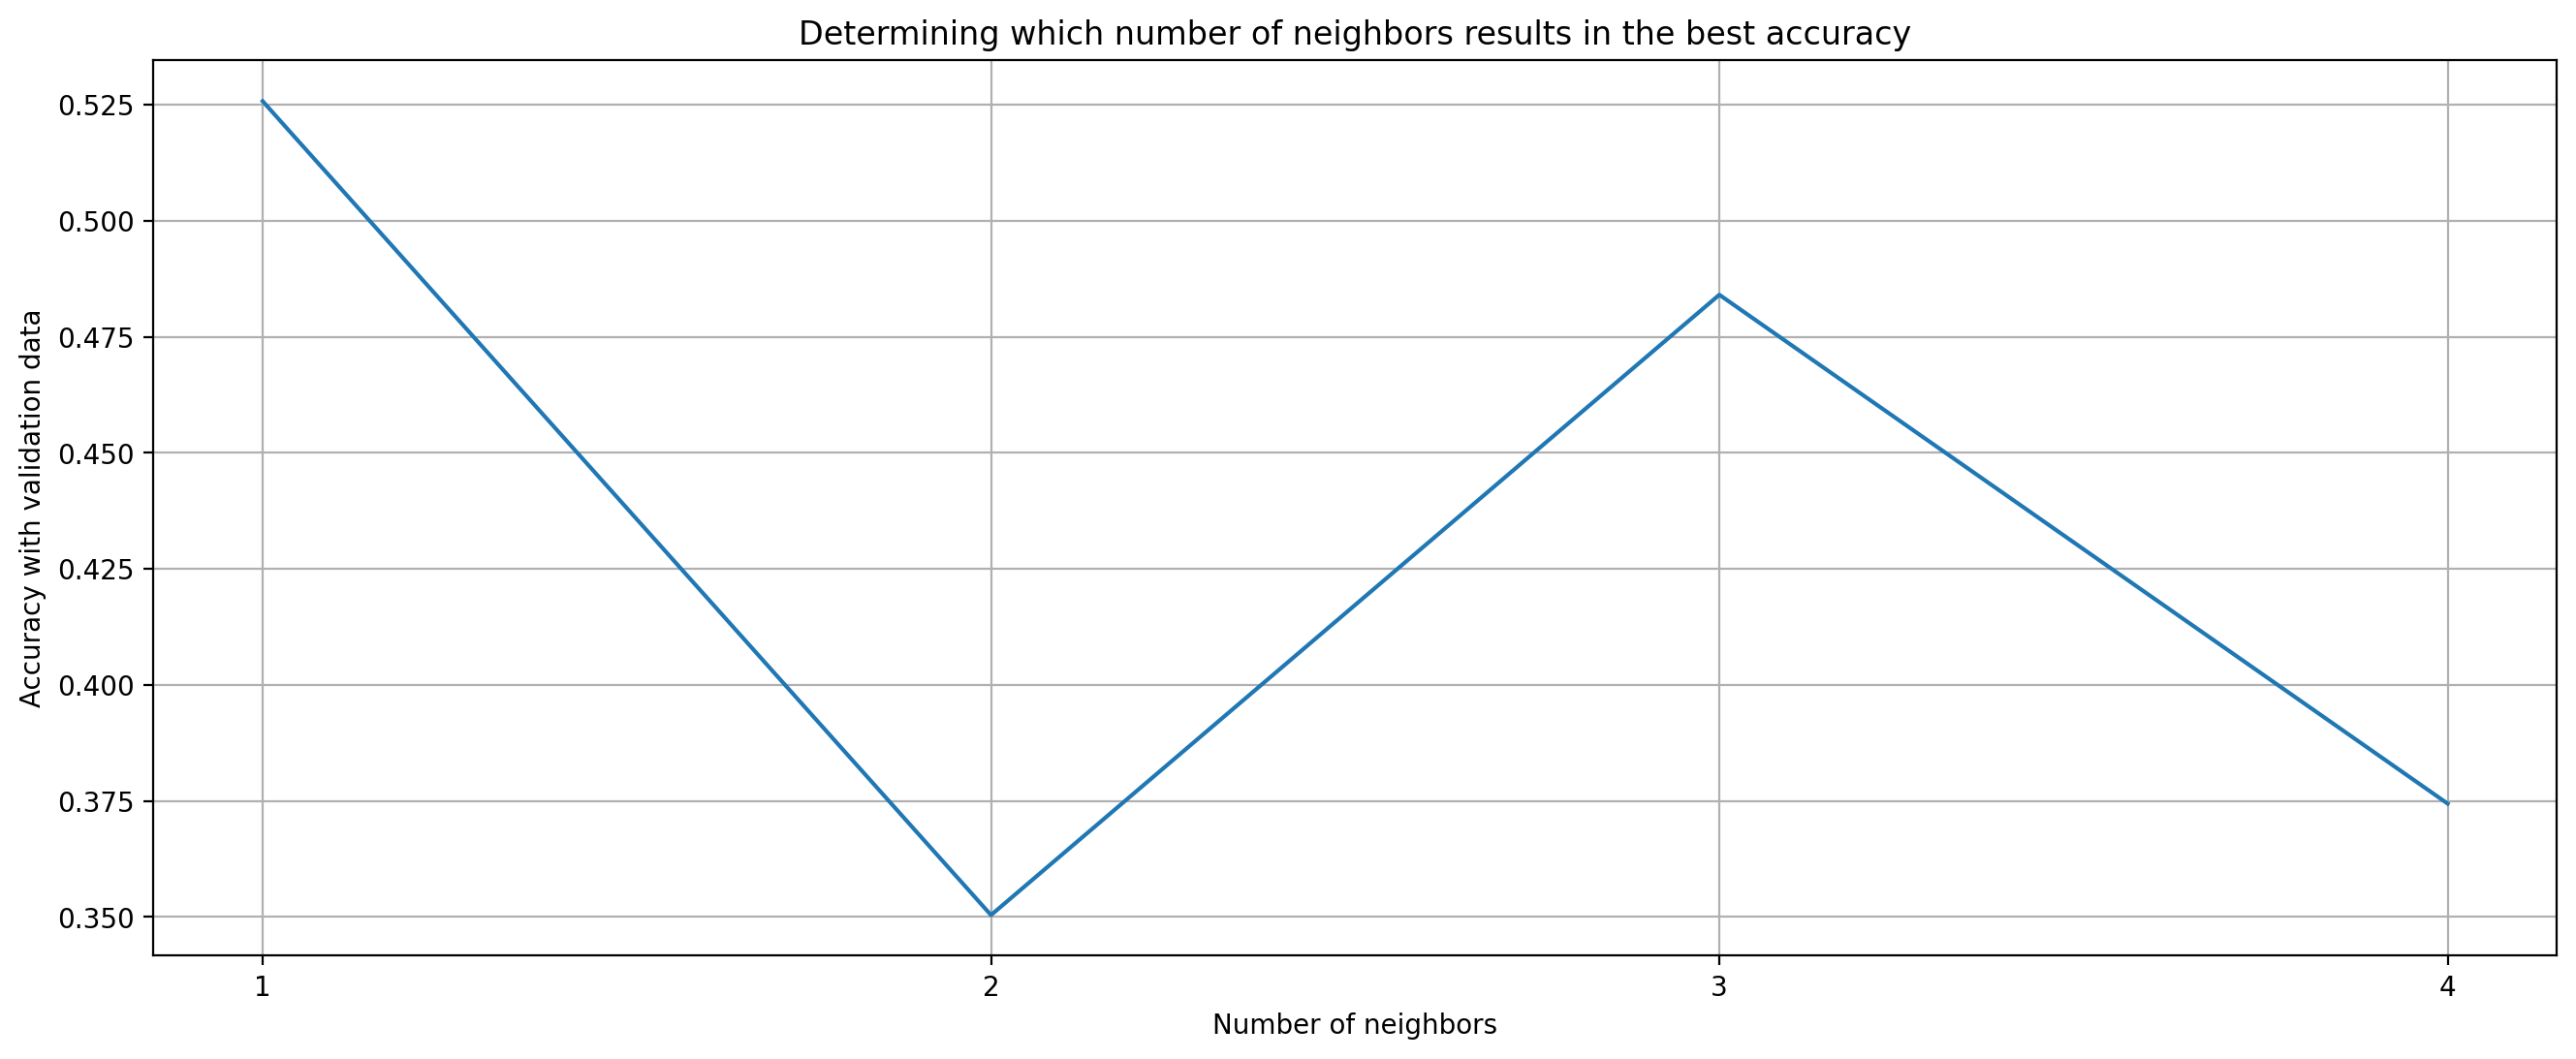

In [98]:
plt.figure(figsize=(16, 6), dpi=200)
plt.title("Determining which number of neighbors results in the best accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy with validation data")
plt.plot(scores[:,0], scores[:,1])
plt.xticks(np.linspace(1, 4, 4))
plt.grid()
plt.show()

In [99]:
neighbors = int(scores[:, :1].ravel()[np.argmax(scores[:, 1:])])
model = KNeighborsClassifier(neighbors).fit(X_train, y_train)
score = model.score(X_val, y_val)

In [100]:
print(
    '''
    Aus diesem Plot kann man sehen,\n 
    welches Modell die höchste Accuracy hat.\n
    Wir setzen für den {} die Anzhal {} = {},\n
    und erhalten damit eine Accuracy von ca. {}%
    '''.format(
        model.__class__.__name__,
        "neighbors",
        neighbors,
        np.round(score, 2)
    )
)


    Aus diesem Plot kann man sehen,
 
    welches Modell die höchste Accuracy hat.

    Wir setzen für den KNeighborsClassifier die Anzhal neighbors = 1,

    und erhalten damit eine Accuracy von ca. 0.53%
    


## Random Forest Classifier

Hier trainieren wir mehrere Modelle, welche wir anhand verschiedener Anzahl Neighbors erstellen. Für jedes Modell berechnen wir die Accuracy und speichern diese ab.

In [101]:
scores = np.array([(i, RandomForestClassifier(n_estimators=i).fit(X_train, y_train).score(X_val, y_val)) for i in tqdm(range(10, 20))])

  0%|          | 0/10 [00:00<?, ?it/s]

Um zu entscheiden, wieviel Neighbors man für das Modell nehmen soll, visualisieren wir hier die Accuracy für jeden Wert.

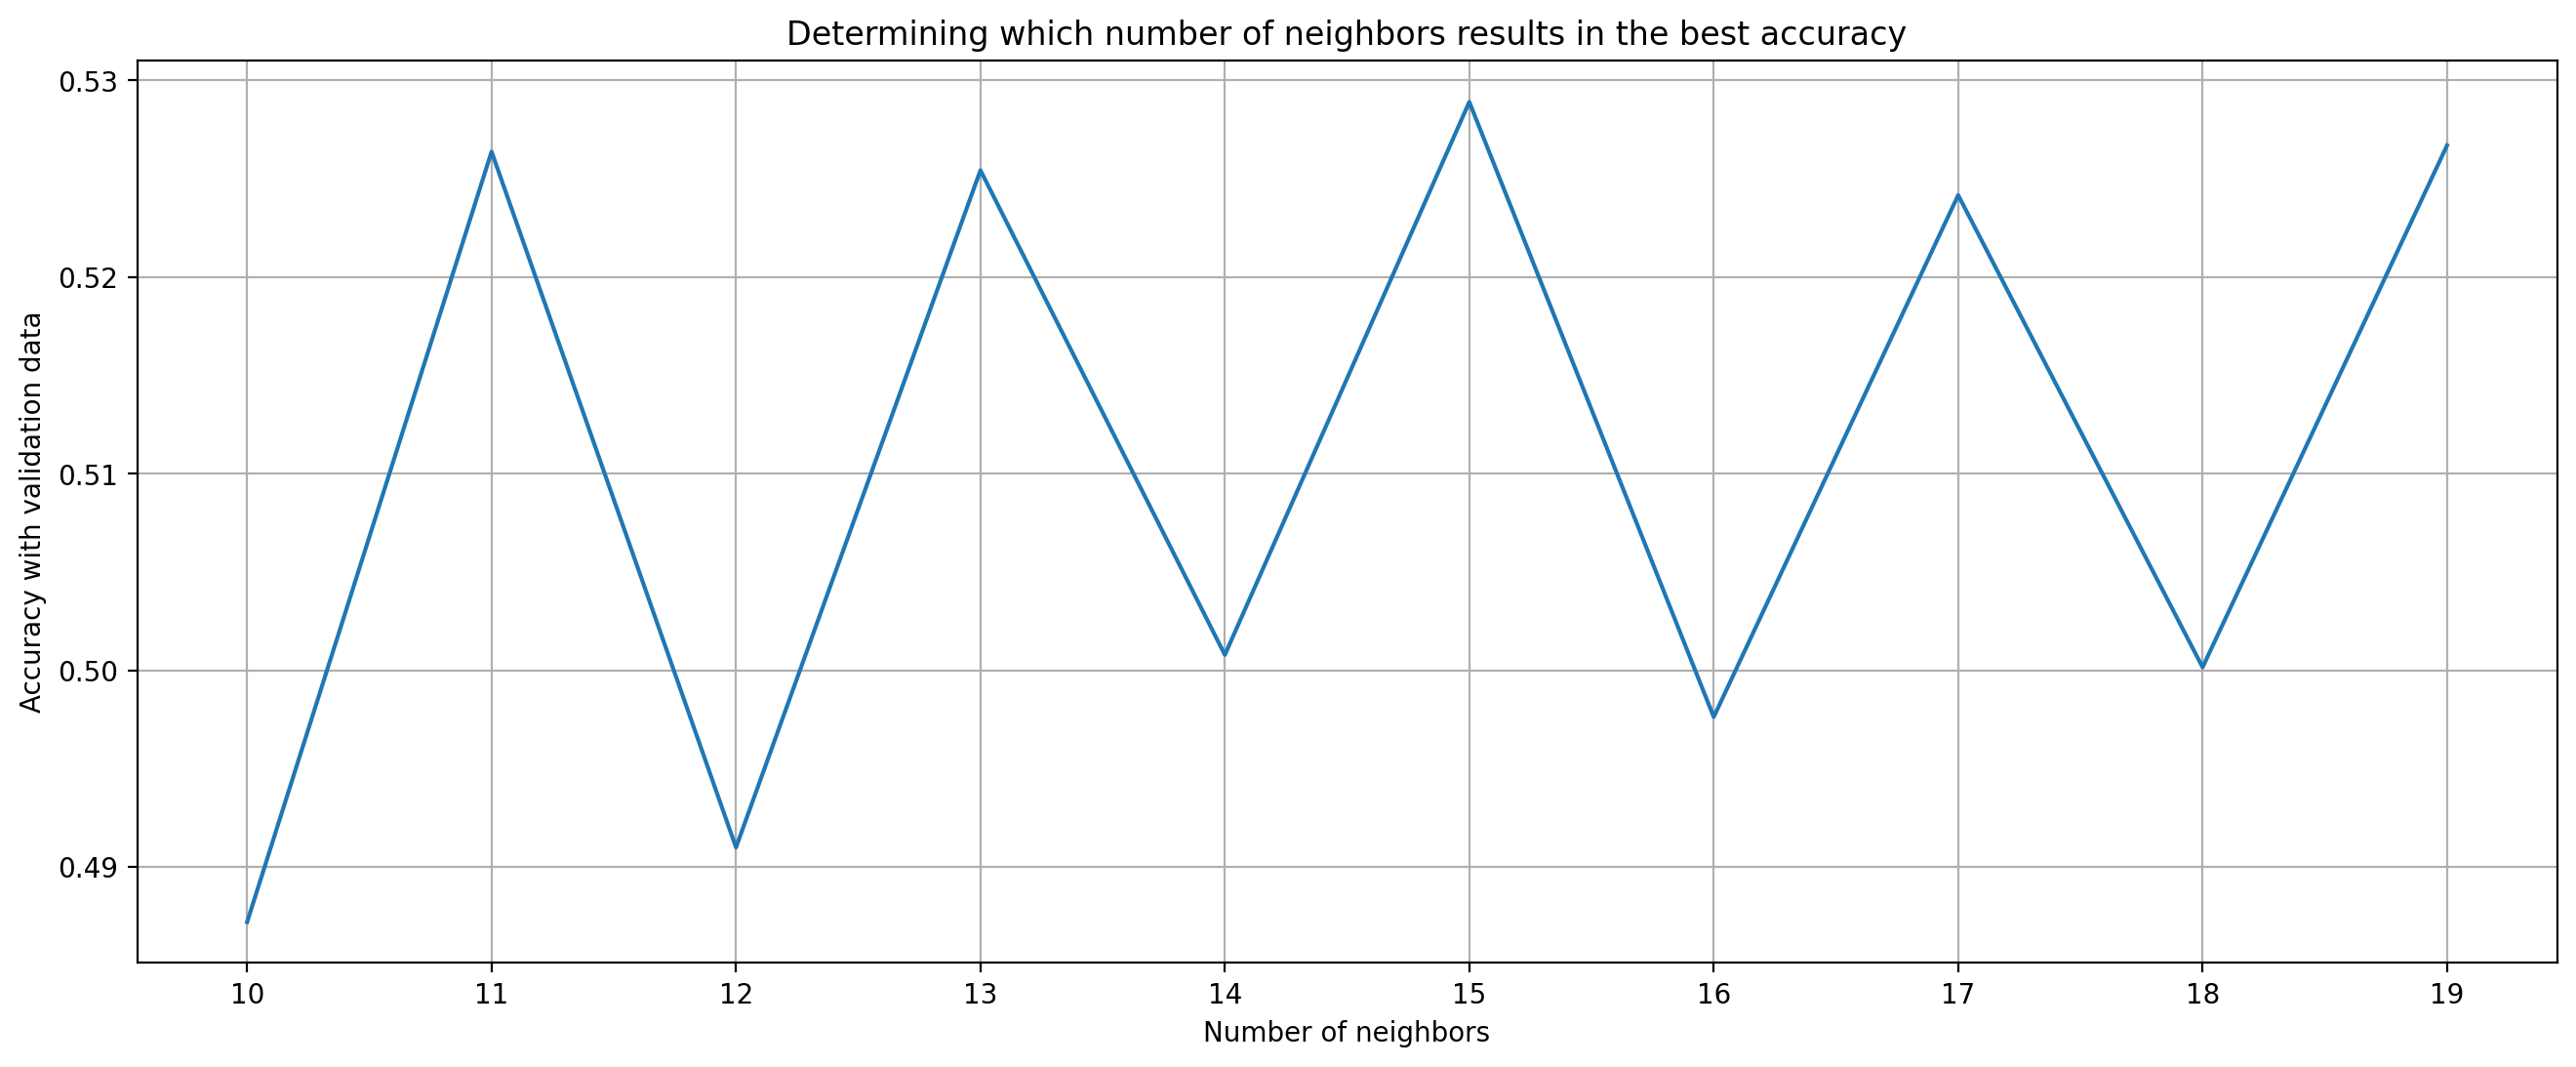

In [102]:
plt.figure(figsize=(16, 6), dpi=200)
plt.title("Determining which number of neighbors results in the best accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy with validation data")
plt.plot(scores[:,0], scores[:,1])
plt.xticks(np.linspace(10, 19, 10))
plt.grid()
plt.show()

In [103]:
n_estimators = int(scores[:, :1].ravel()[np.argmax(scores[:, 1:])])
model = RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train)
score = model.score(X_val, y_val)

In [105]:
print(
    '''
    Aus diesem Plot kann man sehen,\n 
    welches Modell die höchste Accuracy hat.\n
    Wir setzen für den {} den Parameter {} = {} (number of trees in the model),\n
    und erhalten damit eine Accuracy von ca. {}%
    '''.format(
        model.__class__.__name__,
        "n_estimators",
        n_estimators,
        np.round(score, 2)
    )
)


    Aus diesem Plot kann man sehen,
 
    welches Modell die höchste Accuracy hat.

    Wir setzen für den RandomForestClassifier den Parameter n_estimators = 15 (number of trees in the model),

    und erhalten damit eine Accuracy von ca. 0.52%
    
